In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, sqrt
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans


X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape
df = pd.read_csv("data.csv",nrows=5000)

Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y[Y==10] = 0
Y.shape





scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)


def proba(labels):
    prob = [0,0,0,0,0,0,0,0,0,0]
    for i in labels:
        prob[i] += 1
    for i in range(len(prob)):
        prob[i] /= len(labels)

    return prob
def predict(x_train, y , x, k):

    point_dist = []

    for j in range(len(x_train)): 
        #calcule des disatnces
        distances = np.sum((x_train[j,:] - x)**2)
        point_dist.append(distances)
    point_dist = np.array(point_dist) 

    dist = np.argsort(point_dist)[:k] 

    labels = y[dist]
    #  retourner la probabilité du test pour X 
    return proba(labels)
def probToPred(proba):
    max = 0
    for i in range(0,len(proba)):
        if proba[i] > proba[max]:
            max = i
    return max
def svmtrain(Xt, Yt):
    #Créer le modèle
    model= svm.SVC(kernel='linear') 
    # entrainement 
    model.fit(Xt, Yt)
    return model
def knnPredict(Xt, Yt, Xtt, k):
    Ytt = np.array([probToPred(predict(Xt,Yt,x,k)) for x in Xtt])
    return Ytt
def knnPredictProba(Xt, Yt, Xtt, k):
    Ytt = np.array([predict(Xt,Yt,x,k) for x in Xtt])
    return Ytt

def knntrain(Xt, Yt,k):
    #Créer le modèle
    model= KNeighborsClassifier(n_neighbors=k) 
    # entrainement 
    model.fit(Xt, Yt)
    return model
def treetrain(Xt, Yt):
    #Créer le modèle
    model= DecisionTreeClassifier() 
    # entrainement 
    model.fit(Xt, Yt)
    return model
def mlptrain(Xt, Yt):
    #Créer le modèle
    model= MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000) 
    # entrainement 
    model.fit(Xt, Yt)
    return model
class ConfMatrix:
    def __init__(self, ypred, Ytt):
        self.matrice = np.matrix(np.zeros((10,10)))
        self.total=0
        for i in range(0, len(Ytt)):
            self.matrice[ypred[i],Ytt[i]] += 1
            self.total += 1
    def __str__(self):
        return str(self.matrice)

class ConfMatrixSeuil:
    def __init__(self, ypred, Ytt, seuil):
        self.matrice = np.matrix(np.zeros((10,10)))
        self.total=0
        for i in range(0, len(Ytt)):
            for j in range(0,len(ypred[i])):
                if(ypred[i][j] > seuil):
                    self.matrice[j,Ytt[i]] += 1
                    self.total += 1
    def __str__(self):
        return str(self.matrice)

class MetricsSeuil:
    def __init__(self,Xt,Yt,Xtt,Ytt,k):
        self.Xt = Xt
        self.Yt = Yt
        self.Xtt = Xtt
        self.Ytt = Ytt
        self.k = k;
        self.svm = svm.SVC(kernel='linear',probability=True)
        self.svm.fit(Xt,Yt)
        self.tree = DecisionTreeClassifier()
        self.tree.fit(Xt, Yt)
        self.mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
        self.mlp.fit(Xt, Yt)
        self.KnnYt  = knnPredictProba(self.Xt,self.Yt,self.Xtt,self.k)
        self.SvmYt = self.svm.predict_proba(self.Xtt)
        self.TreeYt = self.tree.predict_proba(self.Xtt)
        self.MlpYt =self.mlp.predict_proba(self.Xtt)
    def matrices(self,seuil):
        self.KnnMat = ConfMatrixSeuil(self.KnnYt, self.Ytt,seuil)
        self.SvmMat = ConfMatrixSeuil(self.SvmYt, self.Ytt,seuil)
        self.TreeMat = ConfMatrixSeuil(self.TreeYt, self.Ytt,seuil)
        self.MlpMat = ConfMatrixSeuil(self.MlpYt, self.Ytt,seuil)
        
    def TPFPTNFN(self):
        self.TP = {}
        self.FP = {}
        self.TN = {}
        self.FN = {}
        self.TP["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.TP["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.TP["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.TP["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["MLP"] = [0,0,0,0,0,0,0,0,0,0]

        for i in range(0,10):
            self.TP["Knn"][i] += self.KnnMat.matrice[i,i]
            self.TP["SVM"][i] += self.SvmMat.matrice[i,i]
            self.TP["TREE"][i] += self.TreeMat.matrice[i,i]
            self.TP["MLP"][i] += self.MlpMat.matrice[i,i]

            self.FP["Knn"][i] += self.KnnMat.matrice[:,i].sum() - self.KnnMat.matrice[i,i]
            self.FP["SVM"][i] += self.SvmMat.matrice[:,i].sum() - self.SvmMat.matrice[i,i]
            self.FP["TREE"][i] += self.TreeMat.matrice[:,i].sum() - self.TreeMat.matrice[i,i]
            self.FP["MLP"][i] += self.MlpMat.matrice[:,i].sum() - self.MlpMat.matrice[i,i]

            self.FN["Knn"][i] += self.KnnMat.matrice[i,:].sum() - self.KnnMat.matrice[i,i]
            self.FN["SVM"][i] += self.SvmMat.matrice[i,:].sum() - self.SvmMat.matrice[i,i]
            self.FN["TREE"][i] += self.TreeMat.matrice[i,:].sum() - self.TreeMat.matrice[i,i]
            self.FN["MLP"][i] += self.MlpMat.matrice[i,:].sum() - self.MlpMat.matrice[i,i]

            self.TN["Knn"][i] += self.KnnMat.total - self.TP["Knn"][i] - self.FP["Knn"][i] - self.FN["Knn"][i]
            self.TN["SVM"][i] += self.SvmMat.total - self.TP["SVM"][i] - self.FP["SVM"][i] - self.FN["SVM"][i]
            self.TN["TREE"][i] += self.TreeMat.total - self.TP["TREE"][i] - self.FP["TREE"][i] - self.FN["TREE"][i]
            self.TN["MLP"][i] += self.MlpMat.total - self.TP["MLP"][i] - self.FP["MLP"][i] - self.FN["MLP"][i]
    def TPRcalc(self):
        self.TPR={}
        self.TPR["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.TPR["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.TPR["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.TPR["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        for i in range(0,10):
            self.TPR["Knn"][i] = self.TP["Knn"][i]/(self.TP["Knn"][i]+self.FN["Knn"][i])
            self.TPR["SVM"][i] = self.TP["SVM"][i]/(self.TP["SVM"][i]+self.FN["SVM"][i])
            self.TPR["TREE"][i] = self.TP["TREE"][i]/(self.TP["TREE"][i]+self.FN["TREE"][i])
            self.TPR["MLP"][i] = self.TP["MLP"][i]/(self.TP["MLP"][i]+self.FN["MLP"][i])
        return self.TPR
    def FPRcalc(self):
        self.FPR={}
        self.FPR["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.FPR["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.FPR["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.FPR["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        for i in range(0,10):
            self.FPR["Knn"][i] = self.FP["Knn"][i]/(self.FP["Knn"][i]+self.TN["Knn"][i])
            self.FPR["SVM"][i] = self.FP["SVM"][i]/(self.FP["SVM"][i]+self.TN["SVM"][i])
            self.FPR["TREE"][i] = self.FP["TREE"][i]/(self.FP["TREE"][i]+self.TN["TREE"][i])
            self.FPR["MLP"][i] = self.FP["MLP"][i]/(self.FP["MLP"][i]+self.TN["MLP"][i])
        return self.FPR



class Metrics:
    def __init__(self,Xt,Yt,Xtt,Ytt,k):
        self.Xt = Xt
        self.Yt = Yt
        self.Xtt = Xtt
        self.Ytt = Ytt
        self.k = k;
        self.svm = svm.SVC(kernel='linear')
        self.svm.fit(Xt,Yt)
        self.tree = DecisionTreeClassifier()
        self.tree.fit(Xt, Yt)
        self.mlp = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
        self.mlp.fit(Xt, Yt)
    
    def matrices(self):
        self.KnnMat = ConfMatrix(knnPredict(self.Xt,self.Yt,self.Xtt,self.k), self.Ytt)
        self.SvmMat = ConfMatrix(self.svm.predict(self.Xtt), self.Ytt)
        self.TreeMat = ConfMatrix(self.tree.predict(self.Xtt), self.Ytt)
        self.MlpMat = ConfMatrix(self.mlp.predict(self.Xtt), self.Ytt)
        
    
    def TPFPTNFN(self):
        self.TP = {}
        self.FP = {}
        self.TN = {}
        self.FN = {}
        self.TP["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.TP["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.TP["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.TP["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.FP["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.TN["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.FN["MLP"] = [0,0,0,0,0,0,0,0,0,0]

        for i in range(0,10):
            self.TP["Knn"][i] += self.KnnMat.matrice[i,i]
            self.TP["SVM"][i] += self.SvmMat.matrice[i,i]
            self.TP["TREE"][i] += self.TreeMat.matrice[i,i]
            self.TP["MLP"][i] += self.MlpMat.matrice[i,i]

            self.FP["Knn"][i] += self.KnnMat.matrice[:,i].sum() - self.KnnMat.matrice[i,i]
            self.FP["SVM"][i] += self.SvmMat.matrice[:,i].sum() - self.SvmMat.matrice[i,i]
            self.FP["TREE"][i] += self.TreeMat.matrice[:,i].sum() - self.TreeMat.matrice[i,i]
            self.FP["MLP"][i] += self.MlpMat.matrice[:,i].sum() - self.MlpMat.matrice[i,i]

            self.FN["Knn"][i] += self.KnnMat.matrice[i,:].sum() - self.KnnMat.matrice[i,i]
            self.FN["SVM"][i] += self.SvmMat.matrice[i,:].sum() - self.SvmMat.matrice[i,i]
            self.FN["TREE"][i] += self.TreeMat.matrice[i,:].sum() - self.TreeMat.matrice[i,i]
            self.FN["MLP"][i] += self.MlpMat.matrice[i,:].sum() - self.MlpMat.matrice[i,i]

            self.TN["Knn"][i] += self.KnnMat.total - self.TP["Knn"][i] - self.FP["Knn"][i] - self.FN["Knn"][i]
            self.TN["SVM"][i] += self.SvmMat.total - self.TP["SVM"][i] - self.FP["SVM"][i] - self.FN["SVM"][i]
            self.TN["TREE"][i] += self.TreeMat.total - self.TP["TREE"][i] - self.FP["TREE"][i] - self.FN["TREE"][i]
            self.TN["MLP"][i] += self.MlpMat.total - self.TP["MLP"][i] - self.FP["MLP"][i] - self.FN["MLP"][i]


        print("KNN")
        print(self.TP["Knn"])
        print(self.TN["Knn"])
        print(self.FP["Knn"])
        print(self.FN["Knn"])
        print("SVM")
        print(self.TP["SVM"])
        print(self.TN["SVM"])
        print(self.FP["SVM"])
        print(self.FN["SVM"])
        print("TREE")
        print(self.TP["TREE"])
        print(self.TN["TREE"])
        print(self.FP["TREE"])
        print(self.FN["TREE"])
        print("MLP")
        print(self.TP["MLP"])
        print(self.TN["MLP"])
        print(self.FP["MLP"])
        print(self.FN["MLP"])

    def Calc(self):
        self.Rappel = {}
        self.Rappel["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.Rappel["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.Rappel["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.Rappel["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.Precision = {}
        self.Precision["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.Precision["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.Precision["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.Precision["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.TFP = {}
        self.TFP["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.TFP["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.TFP["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.TFP["MLP"] = [0,0,0,0,0,0,0,0,0,0]
        self.specificité = {}
        self.specificité["Knn"] = [0,0,0,0,0,0,0,0,0,0]
        self.specificité["SVM"] = [0,0,0,0,0,0,0,0,0,0]
        self.specificité["TREE"] = [0,0,0,0,0,0,0,0,0,0]
        self.specificité["MLP"] = [0,0,0,0,0,0,0,0,0,0]

        for i in range(0,len(self.Rappel["Knn"])):
            self.Rappel["Knn"][i] = self.TP["Knn"][i] / (self.TP["Knn"][i] +  self.FN["Knn"][i])
            self.Rappel["SVM"][i] = self.TP["SVM"][i] / (self.TP["SVM"][i] +  self.FN["SVM"][i])
            self.Rappel["TREE"][i] = self.TP["TREE"][i] / (self.TP["TREE"][i] +  self.FN["TREE"][i])
            self.Rappel["MLP"][i] = self.TP["MLP"][i] / (self.TP["MLP"][i] +  self.FN["MLP"][i])

            self.Precision["Knn"][i] = self.TP["Knn"][i] / (self.TP["Knn"][i] +  self.FP["Knn"][i])
            self.Precision["SVM"][i] = self.TP["SVM"][i] / (self.TP["SVM"][i] +  self.FP["SVM"][i])
            self.Precision["TREE"][i] = self.TP["TREE"][i] / (self.TP["TREE"][i] +  self.FP["TREE"][i])
            self.Precision["MLP"][i] = self.TP["MLP"][i] / (self.TP["MLP"][i] +  self.FP["MLP"][i])

            self.specificité["Knn"][i] = self.TN["Knn"][i] / (self.TN["Knn"][i] +  self.FN["Knn"][i])
            self.specificité["SVM"][i] = self.TN["SVM"][i] / (self.TN["SVM"][i] +  self.FN["SVM"][i])
            self.specificité["TREE"][i] = self.TN["TREE"][i] / (self.TN["TREE"][i] +  self.FN["TREE"][i])
            self.specificité["MLP"][i] = self.TN["MLP"][i] / (self.TN["MLP"][i] +  self.FN["MLP"][i])

            self.TFP["Knn"][i] = self.FP["Knn"][i] / (self.FP["Knn"][i] +  self.TN["Knn"][i])
            self.TFP["SVM"][i] = self.FP["SVM"][i] / (self.FP["SVM"][i] +  self.TN["SVM"][i])
            self.TFP["TREE"][i] = self.FP["TREE"][i] / (self.FP["TREE"][i] +  self.TN["TREE"][i])
            self.TFP["MLP"][i] = self.FP["MLP"][i] / (self.FP["MLP"][i] +  self.TN["MLP"][i])

print("done")

done


In [80]:
TPRtable = {}
FPRtable = {}
TPRtable["Knn"] = []
TPRtable["SVM"] = []
TPRtable["TREE"] = []
TPRtable["MLP"] = []

FPRtable["Knn"]  = []
FPRtable["SVM"]  = []
FPRtable["TREE"]  = []
FPRtable["MLP"]  = []

max = 100
MetricsS = MetricsSeuil(Xt,Yt,Xtt,Ytt,10)
for i in range(1,max):

    MetricsS.matrices(i/max)
    MetricsS.TPFPTNFN()
    tpr = MetricsS.TPRcalc()
    fpr = MetricsS.FPRcalc()
    
    TPRtable["Knn"].append(tpr["Knn"])
    TPRtable["SVM"].append(tpr["SVM"])
    TPRtable["TREE"].append(tpr["TREE"])
    TPRtable["MLP"].append(tpr["MLP"])

    FPRtable["Knn"].append(fpr["Knn"])
    FPRtable["SVM"].append(fpr["SVM"])
    FPRtable["TREE"].append(fpr["TREE"])
    FPRtable["MLP"].append(fpr["MLP"])


met = Metrics(Xt,Yt,Xtt,Ytt,10)
met.matrices()
met.TPFPTNFN()
met.Calc()



KNN
[137.0, 152.0, 127.0, 139.0, 126.0, 126.0, 131.0, 121.0, 121.0, 118.0]
[1349.0, 1311.0, 1345.0, 1310.0, 1325.0, 1313.0, 1342.0, 1340.0, 1331.0, 1332.0]
[2.0, 2.0, 22.0, 22.0, 19.0, 44.0, 15.0, 28.0, 28.0, 20.0]
[12.0, 35.0, 6.0, 29.0, 30.0, 17.0, 12.0, 11.0, 20.0, 30.0]
SVM
[136.0, 150.0, 135.0, 142.0, 136.0, 142.0, 133.0, 134.0, 124.0, 122.0]
[1356.0, 1337.0, 1328.0, 1311.0, 1333.0, 1311.0, 1348.0, 1336.0, 1342.0, 1352.0]
[3.0, 4.0, 14.0, 19.0, 9.0, 28.0, 13.0, 15.0, 25.0, 16.0]
[5.0, 9.0, 23.0, 28.0, 22.0, 19.0, 6.0, 15.0, 9.0, 10.0]
TREE
[122.0, 130.0, 99.0, 124.0, 109.0, 115.0, 118.0, 115.0, 103.0, 99.0]
[1354.0, 1321.0, 1315.0, 1289.0, 1319.0, 1288.0, 1322.0, 1319.0, 1287.0, 1320.0]
[17.0, 24.0, 50.0, 37.0, 36.0, 55.0, 28.0, 34.0, 46.0, 39.0]
[7.0, 25.0, 36.0, 50.0, 36.0, 42.0, 32.0, 32.0, 64.0, 42.0]
MLP
[138.0, 148.0, 138.0, 148.0, 136.0, 151.0, 137.0, 133.0, 129.0, 123.0]
[1358.0, 1337.0, 1333.0, 1318.0, 1341.0, 1318.0, 1344.0, 1341.0, 1345.0, 1346.0]
[1.0, 6.0, 11.0, 13.0,

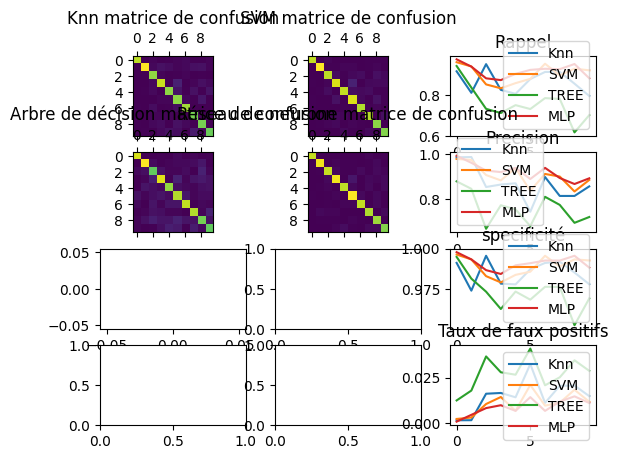

In [94]:
val = [0,1,2,3,4,5,6,7,8,9]

figure, axis = plt.subplots(4, 3)

#matrice de confusion
axis[0,0].matshow(met.KnnMat.matrice)
axis[0,0].set_title("Knn matrice de confusion")
axis[0,1].matshow(met.SvmMat.matrice)
axis[0,1].set_title("SVM matrice de confusion")
axis[1,0].matshow(met.TreeMat.matrice)
axis[1,0].set_title("Arbre de décision matrice de confusion")
axis[1,1].matshow(met.MlpMat.matrice)
axis[1,1].set_title("Réseau de neurone matrice de confusion")

axis[0,2].plot(val, met.Rappel["Knn"],label="Knn")
axis[0,2].plot(val, met.Rappel["SVM"],label="SVM")
axis[0,2].plot(val, met.Rappel["TREE"],label="TREE")
axis[0,2].plot(val, met.Rappel["MLP"],label="MLP")
axis[0,2].set_title("Rappel")
axis[0,2].legend()

axis[1,2].plot(val, met.Precision["Knn"],label="Knn")
axis[1,2].plot(val, met.Precision["SVM"],label="SVM")
axis[1,2].plot(val, met.Precision["TREE"],label="TREE")
axis[1,2].plot(val, met.Precision["MLP"],label="MLP")
axis[1,2].set_title("Precision")
axis[1,2].legend()

axis[2,2].plot(val, met.specificité["Knn"],label="Knn")
axis[2,2].plot(val, met.specificité["SVM"],label="SVM")
axis[2,2].plot(val, met.specificité["TREE"],label="TREE")
axis[2,2].plot(val, met.specificité["MLP"],label="MLP")
axis[2,2].set_title("specificité")
axis[2,2].legend()

axis[3,2].plot(val, met.TFP["Knn"],label="Knn")
axis[3,2].plot(val, met.TFP["SVM"],label="SVM")
axis[3,2].plot(val, met.TFP["TREE"],label="TREE")
axis[3,2].plot(val, met.TFP["MLP"],label="MLP")
axis[3,2].set_title("Taux de faux positifs")
axis[3,2].legend()

fpr0 = [i in FPRtable["SVM"][:][0]]
fpr0.sort()
tpr0 = [i in TPRtable["SVM"][:][0]]
tpr0.sort()
TPRtable["SVM"][:].sort()
FPRtable["Knn"][:].sort()
TPRtable["Knn"][:].sort()
FPRtable["MLP"][:].sort()
TPRtable["MLP"][:].sort()
FPRtable["TREE"][:].sort()
TPRtable["TREE"][:].sort()

axis[2,0].plot(fpr0,tpr0)

plt.show()